In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

from sklearn.datasets import make_classification
from tensorflow.keras.models import load_model

In [2]:
import tensorflow as tf
import keras.backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)


In [3]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.3)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory('./hist_images/train/', 
                                                    batch_size=16, subset="training", 
                                                    class_mode='binary', 
                                                    target_size=(200, 200))
valid_generator = train_datagen.flow_from_directory('./hist_images/train/', 
                                                    batch_size=16, subset="validation", 
                                                    class_mode='binary', 
                                                    target_size=(200, 200))
test_generator = test_datagen.flow_from_directory('./hist_images/test/', 
                                                  batch_size=16, 
                                                  class_mode='binary', 
                                                  target_size=(200, 200),
                                                  shuffle=False)

Found 135731 images belonging to 2 classes.
Found 58169 images belonging to 2 classes.
Found 83100 images belonging to 2 classes.


In [4]:
class_weights = {0:1, 1:1.5}

In [5]:
model_all = keras.models.Sequential([
    keras.applications.EfficientNetB0(input_shape=(200,200,3),weights='imagenet',include_top=False), 
    keras.layers.BatchNormalization(),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model_all.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='breast_cancer_effnetb0-imagenet-all_b0.h5', save_best_only=True, monitor='val_f1'),
    tf.keras.callbacks.ReduceLROnPlateau()
]

model_all.compile(loss="binary_crossentropy",
              optimizer='adam',
              metrics=[
                  f1,
                  keras.metrics.BinaryAccuracy(),
                  keras.metrics.Precision(),
                  keras.metrics.Recall(),
                  keras.metrics.AUC()
              ])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 1280)       5120      
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               1

In [6]:
history = model_all.fit(train_generator,
                     validation_data = valid_generator,
                     callbacks = callbacks,
                     class_weight = class_weights,
                     epochs = 25)

Epoch 1/25
8484/8484 [==============================] - 3378s 395ms/step - loss: 0.4096 - f1: 0.7386 - binary_accuracy: 0.8551 - precision: 0.7225 - recall: 0.7943 - auc: 0.9146 - val_loss: 0.2613 - val_f1: 0.7817 - val_binary_accuracy: 0.8943 - val_precision: 0.8356 - val_recall: 0.7814 - val_auc: 0.9473 - lr: 0.0010
Epoch 2/25
8484/8484 [==============================] - 1517s 179ms/step - loss: 0.3547 - f1: 0.7719 - binary_accuracy: 0.8758 - precision: 0.7564 - recall: 0.8294 - auc: 0.9362 - val_loss: 0.3028 - val_f1: 0.7791 - val_binary_accuracy: 0.8768 - val_precision: 0.7374 - val_recall: 0.8788 - val_auc: 0.9493 - lr: 0.0010
Epoch 3/25
8484/8484 [==============================] - 1497s 176ms/step - loss: 0.3351 - f1: 0.7812 - binary_accuracy: 0.8818 - precision: 0.7642 - recall: 0.8436 - auc: 0.9431 - val_loss: 0.2611 - val_f1: 0.7912 - val_binary_accuracy: 0.8951 - val_precision: 0.8174 - val_recall: 0.8117 - val_auc: 0.9499 - lr: 0.0010
Epoch 4/25
8484/8484 [==================

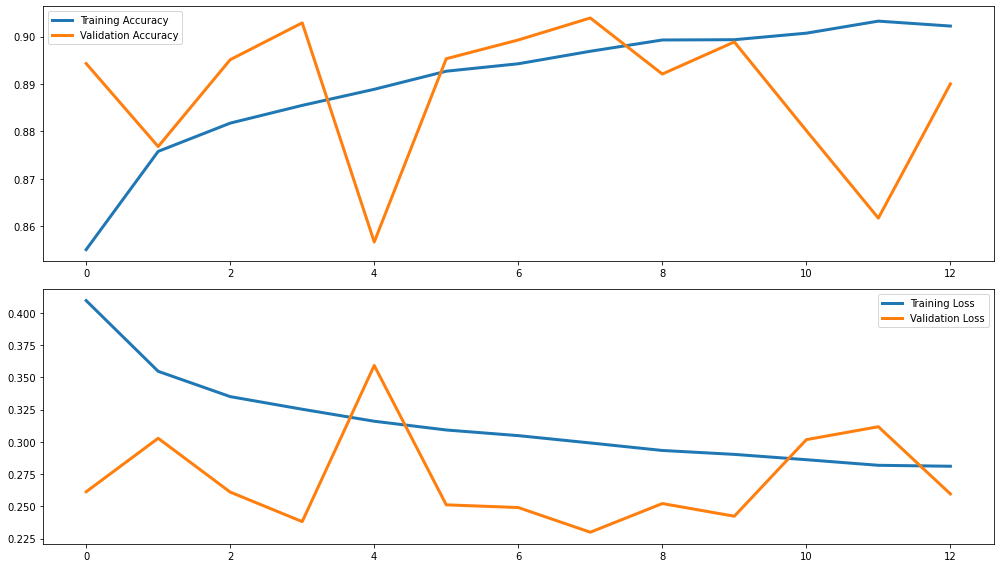

In [7]:
import pandas as pd

model_history = pd.DataFrame(history.history)
model_history['epoch'] = history.epoch

fig, ax = plt.subplots(2, figsize=(14,8))
num_epochs = model_history.shape[0]

ax[0].plot(np.arange(0, num_epochs), model_history["binary_accuracy"], 
        label="Training Accuracy", lw=3)
ax[0].plot(np.arange(0, num_epochs), model_history["val_binary_accuracy"], 
        label="Validation Accuracy", lw=3)

ax[1].plot(np.arange(0, num_epochs), model_history["loss"], 
        label="Training Loss", lw=3)
ax[1].plot(np.arange(0, num_epochs), model_history["val_loss"], 
        label="Validation Loss", lw=3)

ax[0].legend()
ax[1].legend()

plt.tight_layout()
plt.show()

In [15]:
model = load_model('breast_cancer_effnetb0-imagenet-all_b0.h5', custom_objects={'f1':f1})

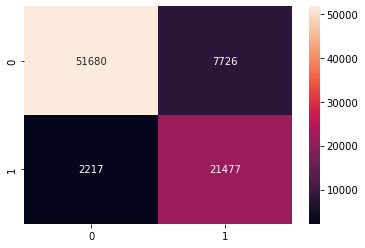

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = model.predict(test_generator)

sns.heatmap(confusion_matrix(test_generator.classes, np.round(y_pred)), annot=True, fmt='g')
plt.show()

In [17]:
model.evaluate(test_generator)

5194/5194 [==============================] - 206s 39ms/step - loss: 0.3061 - f1: 0.2703 - binary_accuracy: 0.8803 - precision: 0.7354 - recall: 0.9064 - auc: 0.9517


[0.3061351776123047,
 0.2702500522136688,
 0.8803489804267883,
 0.7354381680488586,
 0.906432032585144,
 0.9516737461090088]

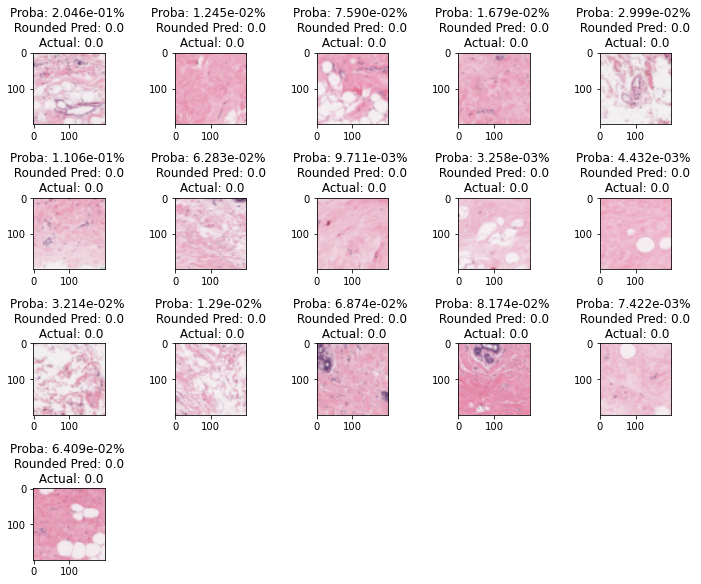

In [18]:
import cv2
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))

batch = next(test_generator)
images = batch[0]
labels = batch[1]

for index, image in enumerate(images):
    ax = fig.add_subplot(5,5,index+1)
    plt.imshow(image.astype('int'))
    
    image = np.expand_dims(image, 0)
    pred = model.predict(image)
    pred = np.squeeze(pred)
    label = labels[index]
    
    ax.set_title(f'Proba: {np.format_float_scientific(pred, precision=3)}% \n Rounded Pred: {np.round(pred)} \n Actual: {label}')
    
    
plt.tight_layout()
plt.show()